# <center>Flight Price Prediction</center>

## Modules

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Initializing the dataframe

In [69]:
df = pd.read_csv("Data_Train.csv")
pd.set_option('display.max_columns', None)
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [71]:
df.shape

(10683, 11)

In [72]:
df.describe(include='O')

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
count,10683,10683,10683,10683,10682,10683,10683,10683,10682,10683
unique,12,44,5,6,128,222,1343,368,5,10
top,Jet Airways,18/05/2019,Delhi,Cochin,DEL → BOM → COK,18:55,19:00,2h 50m,1 stop,No info
freq,3849,504,4537,4537,2376,233,423,550,5625,8345


## Data Wrangling

In [73]:
df.dropna(inplace=True)

In [74]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

##### Changing Date of Journey to datetime

In [75]:
df['JourneyDay'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y').dt.day
df['JourneyMonth'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y').dt.month
df.drop(columns=['Date_of_Journey'], inplace=True)

##### Changing Departure Time to datetime

In [76]:
df['DepartHour'] = pd.to_datetime(df['Dep_Time']).dt.hour
df['DepartMin'] = pd.to_datetime(df['Dep_Time']).dt.minute
df.drop(columns=['Dep_Time'], inplace=True)

##### Changing Arrival Time to datetime

In [77]:
df['ArrivalHour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
df['ArrivalMin'] = pd.to_datetime(df['Arrival_Time']).dt.minute
df.drop(columns=['Arrival_Time'], inplace=True)

In [78]:
'''
    converting "*h" to "*h 0m" &
                "*m" to "0h *m"
'''

duration = list(df['Duration'])

for i in range(len(duration)):
    
    if len(duration[i].split()) != 2:
        if 'h' in duration[i]:
            duration[i] = duration[i].strip() + " 0m"
        else:
            duration[i] = "0h " + duration[i]
            

duration_hours = []
duration_mins = []

for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep="h")[0]))
    duration_mins.append(int(duration[i].split(sep="m")[0].split()[-1]))

In [79]:
df['DurationHours'] = duration_hours
df['DurationMins'] = duration_mins

df.drop(columns=['Duration'], inplace=True)

In [80]:
df.drop(columns=['Route', 'Additional_Info'], inplace=True)

In [81]:
df.head()

,Airline,Source,Destination,Total_Stops,Price,JourneyDay,JourneyMonth,DepartHour,DepartMin,ArrivalHour,ArrivalMin,DurationHours,DurationMins
0,IndiGo,Banglore,New Delhi,non-stop,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2 stops,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2 stops,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1 stop,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1 stop,13302,1,3,16,50,21,35,4,45


## Exploratory Data Analysis

##### Airlines and Prices

In [82]:
df['Airline'].value_counts()

Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: count, dtype: int64

In [83]:
len(df['Airline'].unique())

12

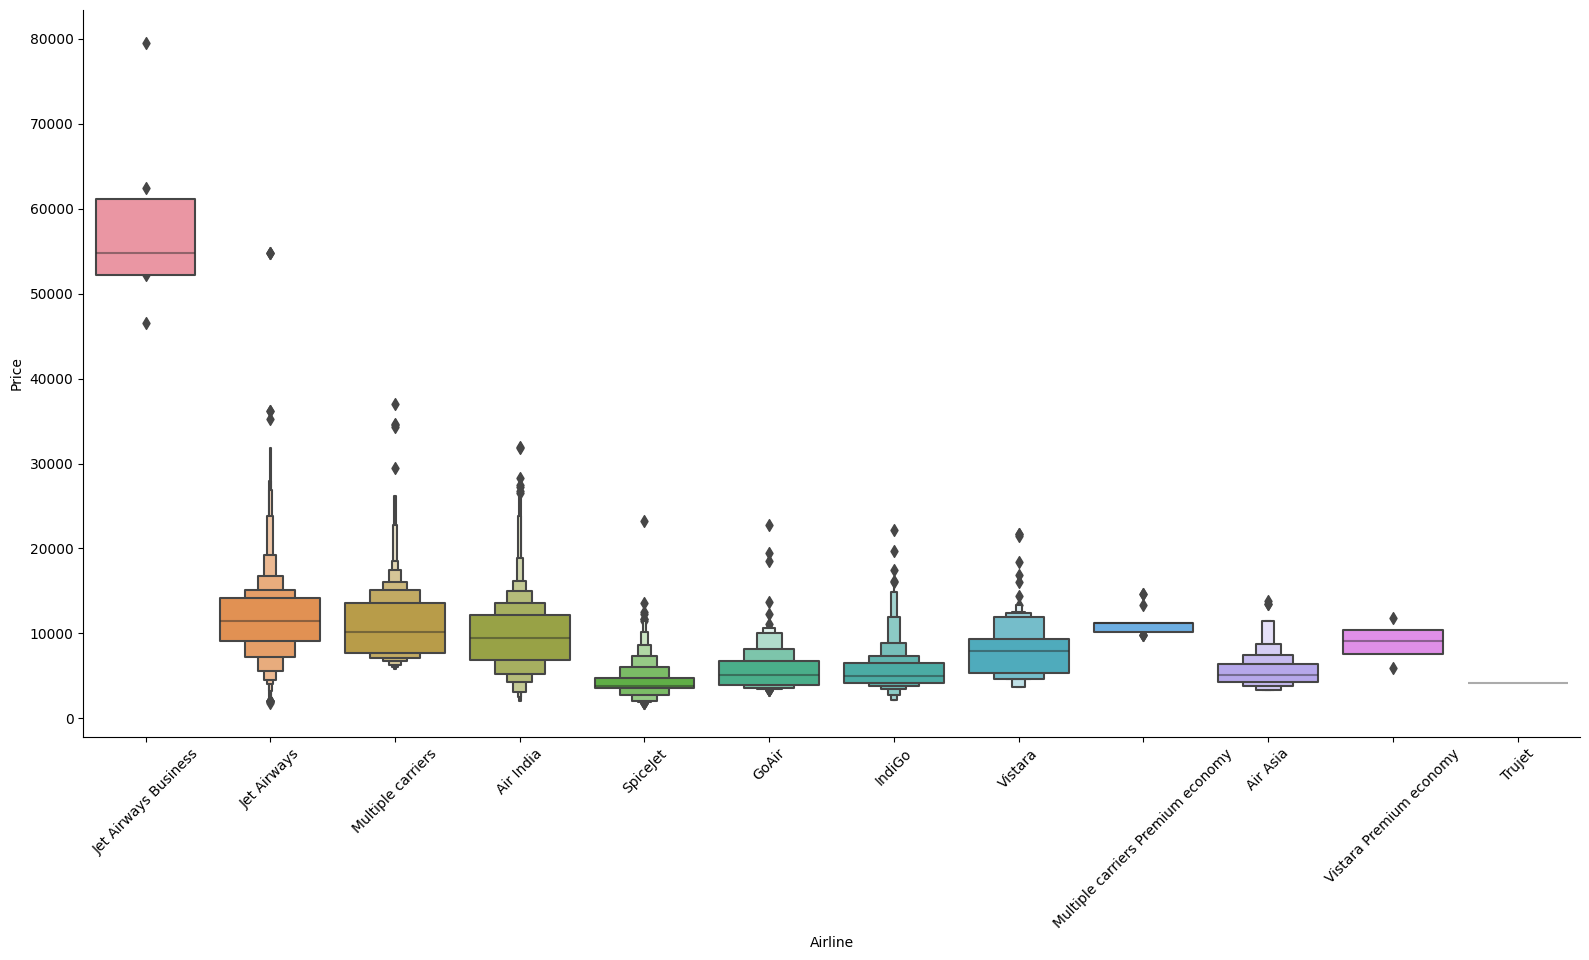

In [84]:
sns.catplot(data=df.sort_values('Price', ascending=False), x='Airline', y='Price', kind='boxen', aspect=2, height=8)
plt.xticks(rotation=45)
plt.show()

##### Sources and Prices

In [85]:
df['Source'].value_counts()

Source
Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: count, dtype: int64

In [86]:
len(df['Source'].unique())

5

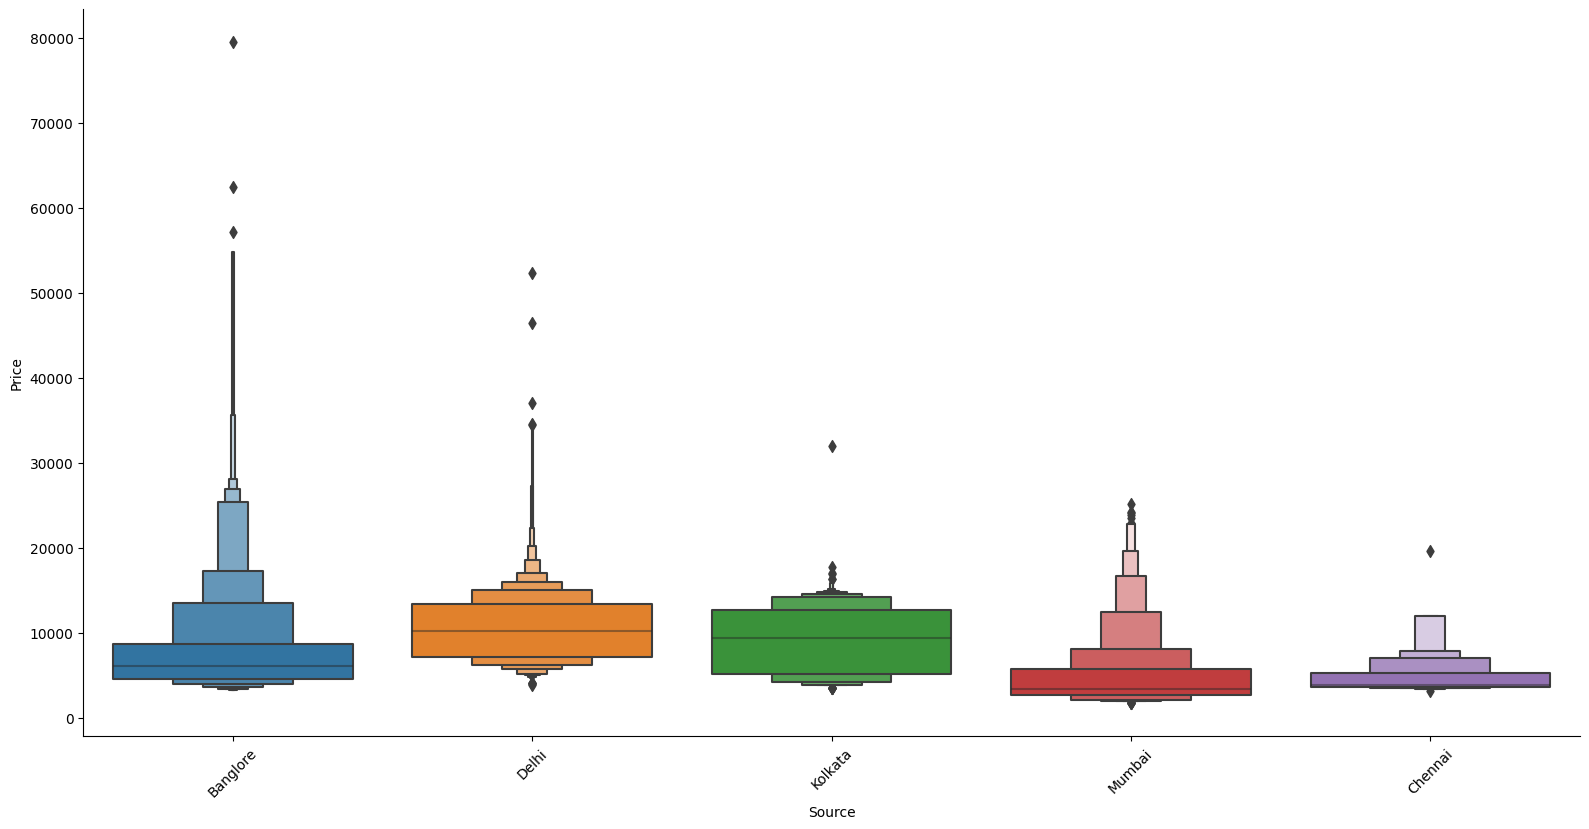

In [87]:
sns.catplot(data=df.sort_values('Price', ascending=False), x='Source', y='Price', kind='boxen', aspect=2, height=8)
plt.xticks(rotation=45)
plt.show()

##### Destinations and Prices

In [88]:
df['Destination'].value_counts()

Destination
Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: count, dtype: int64

In [89]:
len(df['Destination'].unique())

6

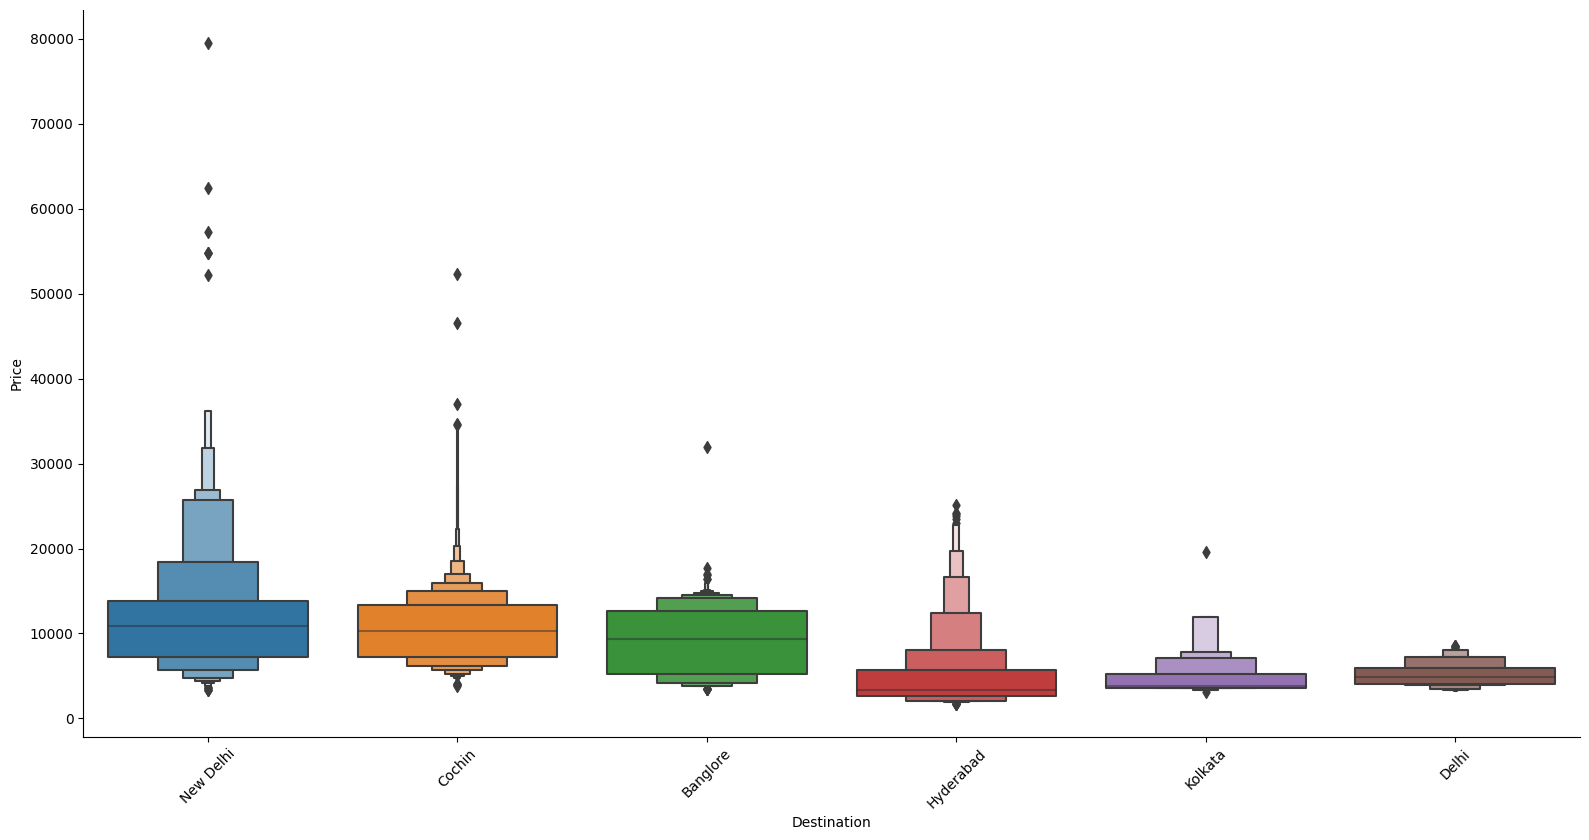

In [90]:
sns.catplot(data=df.sort_values('Price', ascending=False), x='Destination', y='Price', kind='boxen', aspect=2, height=8)
plt.xticks(rotation=45)
plt.show()

## Handle Categorical Data - One Hot Encoding

##### Total Stops

In [91]:
df['Total_Stops'].value_counts()

Total_Stops
1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: count, dtype: int64

In [92]:
df['Total_Stops'].replace({'non-stop':0, '1 stop':1, '2 stops':2, '3 stops':3, '4 stops':4}, inplace=True)

In [93]:
df.head()

,Airline,Source,Destination,Total_Stops,Price,JourneyDay,JourneyMonth,DepartHour,DepartMin,ArrivalHour,ArrivalMin,DurationHours,DurationMins
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,4,45


##### One Hot Encoding - Airlines

In [94]:
Flight = df['Airline']
Flight = pd.get_dummies(Flight, drop_first=True).astype(int)
Flight.head()

,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


##### One Hot Encoding - Source

In [95]:
Source = df['Source']
Source = pd.get_dummies(Source, drop_first=True).astype(int)
Source.head()

,Chennai,Delhi,Kolkata,Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


##### One Hot Encoding - Destination

In [96]:
Dest = df['Destination']
Dest = pd.get_dummies(Dest, drop_first=True).astype(int)
Dest.head()

,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


##### Concatinating the dummies in the dataframe

In [97]:
df.drop(columns=['Airline', 'Source', 'Destination'], inplace=True)
data = pd.concat([df, Flight, Source, Dest], axis=1)
data.head()

,Total_Stops,Price,JourneyDay,JourneyMonth,DepartHour,DepartMin,ArrivalHour,ArrivalMin,DurationHours,DurationMins,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [98]:
data.shape

(10682, 30)

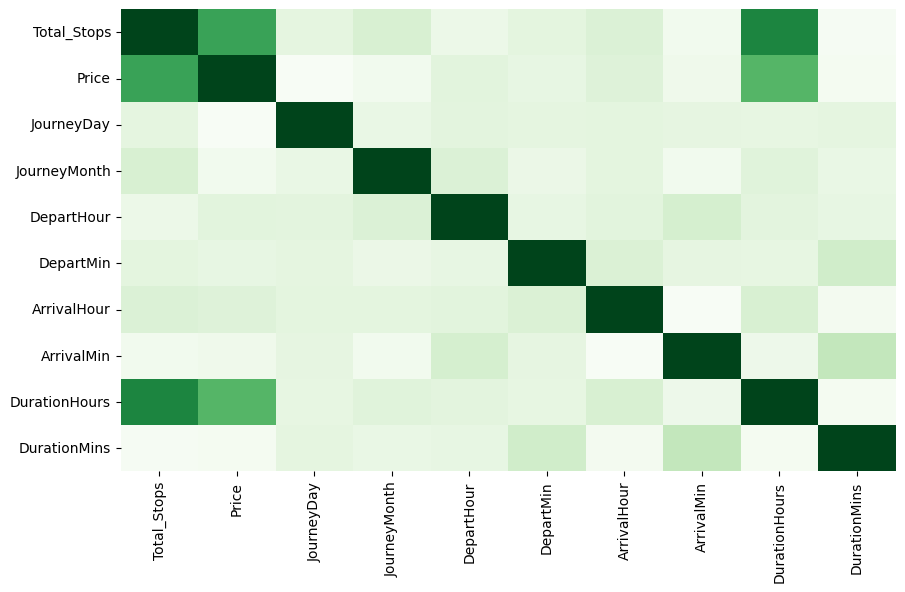

In [99]:
plt.figure(figsize=(10, 6))
sns.heatmap(data=df.corr(), annot=False, cmap='Greens', cbar=False)
plt.show()

We have reduced the multi-collinearity from the dataframe.

## Model Training

In [100]:
X = data.drop(columns=['Price'])
y = data['Price']

In [101]:
extra_tree = ExtraTreesRegressor()
extra_tree.fit(X, y)

ExtraTreesRegressor()

In [102]:
extra_tree.feature_importances_

array([2.38789824e-01, 1.45693924e-01, 5.21708102e-02, 2.39820489e-02,
       2.12135739e-02, 2.71177132e-02, 1.99414924e-02, 1.00444724e-01,
       1.78254678e-02, 9.23210060e-03, 1.79085988e-03, 1.80504557e-02,
       1.47148988e-01, 6.74869233e-02, 1.79947577e-02, 8.62490130e-04,
       2.95659957e-03, 1.18287603e-04, 5.03142433e-03, 8.28205196e-05,
       5.63690824e-04, 1.54625024e-02, 3.09592098e-03, 5.62894430e-03,
       7.77036169e-03, 1.70226597e-02, 6.99885611e-03, 5.03246766e-04,
       2.50185321e-02])

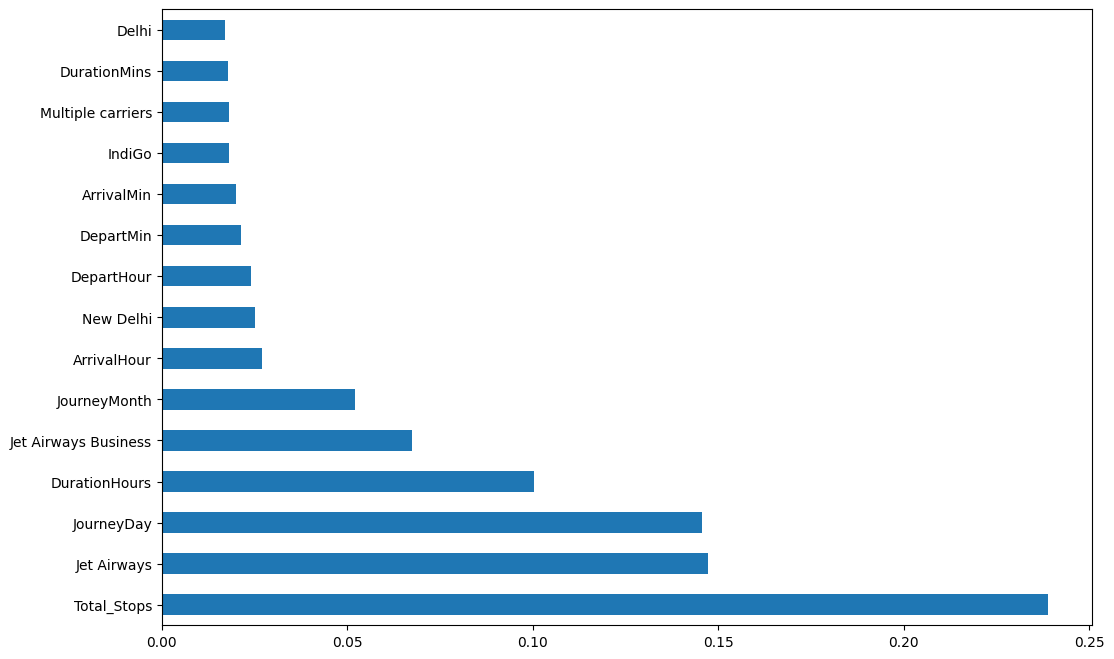

In [103]:
plt.figure(figsize=(12, 8))
feat_importances = pd.Series(extra_tree.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

## Fitting model using Random Forrest

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [106]:
y_pred = rf.predict(X_test)

In [107]:
rf.score(X_train, y_train)

0.953466555300405

In [108]:
rf.score(X_test, y_test)

0.7968990341896434

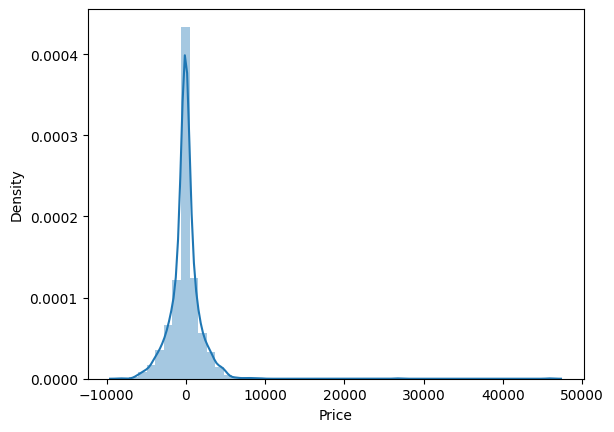

In [109]:
sns.distplot(y_test-y_pred)
plt.show()

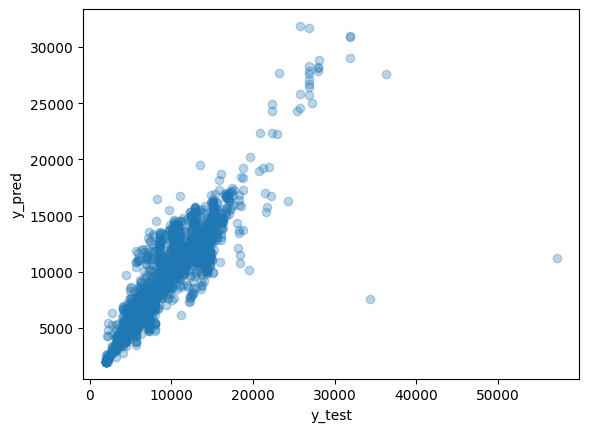

In [110]:
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

In [111]:
print("MAE:", metrics.mean_absolute_error(y_test, y_pred))
print("MSE:", metrics.mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2:", metrics.r2_score(y_test, y_pred))

MAE: 1178.1346663638446
MSE: 4379274.464294566
RMSE: 2092.6716092819165
R2: 0.7968990341896434
